In [1]:
from pathlib import Path
from tqdm.auto import tqdm
import joblib
from captioned_image import CaptionedImage
from PIL import Image
from collections import defaultdict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

EMBEDDINGS_BASE_PATH = Path("embeddings")


plt.rcParams["figure.figsize"] = (30, 15)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.xmargin"] = 0



def normalize(v):
    return v / np.linalg.norm(v)


In [2]:
def train_matching(image_feature_name, text_feature_name, name):
    X_train, y_train = [], []
    texts = joblib.load(EMBEDDINGS_BASE_PATH / f"text_embeddings_train_{name}.p").items()
    for p1, image in tqdm(list(joblib.load(EMBEDDINGS_BASE_PATH / f"image_embeddings_train_{name}.p").items())):
        for p2, image_captions in texts:
            for text in image_captions.values():
                if p1 == p2:
                    X_train.append(normalize(text[text_feature_name]))
                    y_train.append((normalize(image[image_feature_name]), text["class_name"]))

    return MLPRegressor(
        random_state=1, max_iter=300, activation="identity", hidden_layer_sizes=tuple()
    ).fit(X_train, [y[0] for y in y_train])

In [3]:

def evaluate_matching(image_feature_name, text_feature_name, name, mlp):
    X_test, y_test = [], []
    texts = joblib.load(EMBEDDINGS_BASE_PATH / f"text_embeddings_test_{name}.p").items()
    for p1, image in tqdm(list(joblib.load(EMBEDDINGS_BASE_PATH / f"image_embeddings_test_{name}.p").items())):
        for p2, image_captions in texts:
            for text in image_captions.values():
                if p1 == p2:
                    X_test.append(normalize(text[text_feature_name]))
                    y_test.append((normalize(image[image_feature_name]), text["class_name"]))

    print('error: ', mlp.score(X_test, [y[0] for y in y_test]))
    kn = KNeighborsClassifier(n_neighbors=1)
    kn.fit([y[0] for y in y_test], [y[1] for y in y_test])

    predicted = kn.predict(mlp.predict(X_test))

    print(classification_report([y[1] for y in y_test], predicted))
    ConfusionMatrixDisplay.from_predictions(
        y_true=[y[1] for y in y_test],
        y_pred=predicted,
        xticks_rotation="vertical",
        normalize="pred",
        values_format="",
    )
    None

  0%|          | 0/8272 [00:00<?, ?it/s]

  0%|          | 0/3516 [00:00<?, ?it/s]

error:  -0.1623140872663794
                       precision    recall  f1-score   support

     Baltimore Oriole       0.01      0.01      0.01       583
  Blue winged Warbler       0.02      0.01      0.02       595
             Bobolink       0.02      0.03      0.02       588
        Field Sparrow       0.04      0.03      0.03       579
          Florida Jay       0.06      0.13      0.09       584
Golden winged Warbler       0.05      0.01      0.02       586
     Le Conte Sparrow       0.07      0.22      0.10       583
     Least Flycatcher       0.02      0.02      0.02       586
              Mallard       0.00      0.00      0.00       595
      Northern Fulmar       0.08      0.20      0.11       596
  Red faced Cormorant       0.03      0.01      0.01       511
    Ringed Kingfisher       0.12      0.02      0.04       595
      Rusty Blackbird       0.02      0.01      0.01       596
      Scarlet Tanager       0.03      0.04      0.03       587
    Slaty backed Gull     

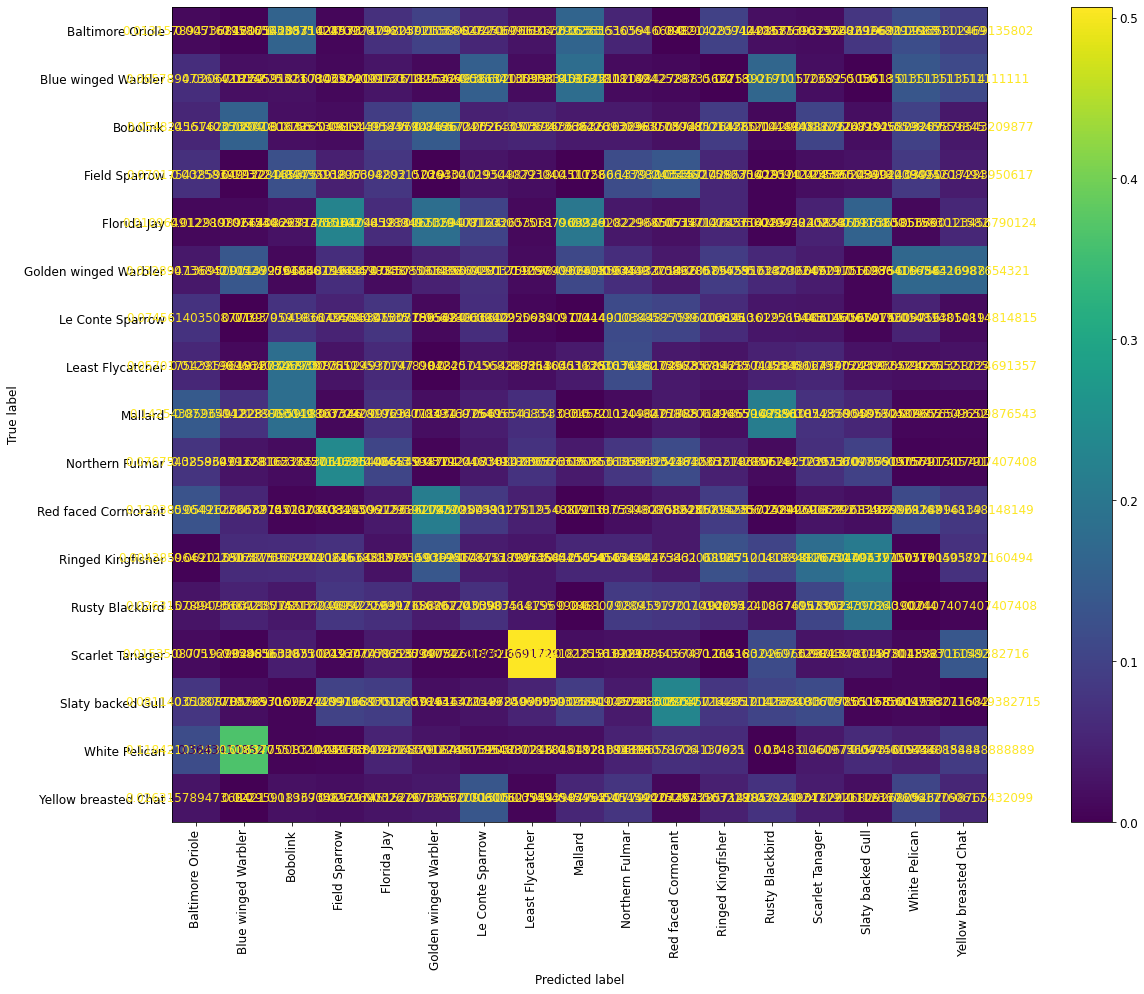

In [4]:

mlp = train_matching("vgg", "bert", 'birds')
evaluate_matching("vgg", "bert", 'birds', mlp)

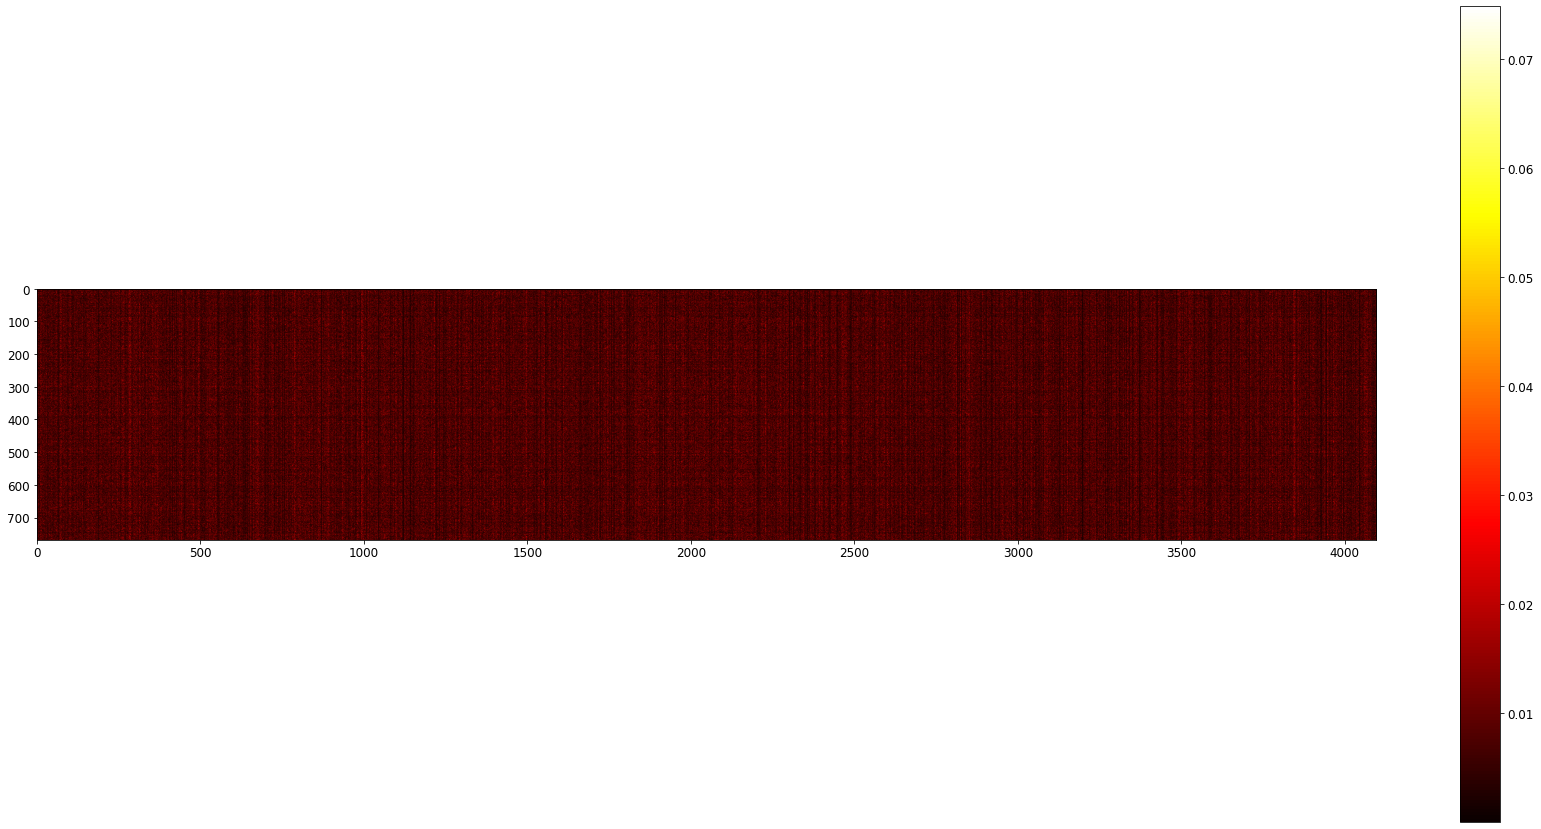

In [5]:
shw = plt.imshow(np.abs(mlp.coefs_[0]), cmap='hot')
bar = plt.colorbar(shw)
plt.show()


In [67]:
from IPython.display import display, HTML
from itertools import product
from random import sample
from math import atan2, sqrt

def show_connections(matrix, q):
    count = round(len(matrix)*q)
    print(count)
    selected = sample(range(len(matrix)), count)
    print(selected)
    
    width = 1500
    height = 900
    size = 20
    def draw_node(i, id, is_left):
        alignment = 'left: 0;' if is_left else 'right: 0;'

        return f'''
            <div style='position: absolute; {alignment} top: {(0.5 + i)/count * 100}%; transform: translateY(-50%); width: {size}px; height: {size}px; background: blue; color: white; border-radius: 1000px;'></div>
        '''

    def draw_connection(i, j, weight):
        delta_y = (j-i)/count
        angle = atan2(delta_y * height, width - size)
        len = sqrt((delta_y * height) ** 2 + (width - size) ** 2)
        scaled_weight = weight ** 4 * 5000000
        if scaled_weight < 1:
            return ''
        return f'''
            <div style='position: absolute; left: {size/2}px; top: {(0.5 + i)/count * 100}%; transform: rotate({angle}rad); width: {len}px; height: {scaled_weight}px; background: hotpink; color: white; transform-origin: center left'></div>
        '''

    return HTML(f'''
        <div style='width: {width}px; height: {height}px; background: white; position: relative'>
            {' '.join(draw_connection(i, j, matrix[i_id][j_id]) for (i, i_id), (j, j_id) in product(enumerate(selected), enumerate(selected)))}
            {' '.join(draw_node(i, id, is_left=True) for i, id in enumerate(selected))}
            {' '.join(draw_node(i, id, is_left=False) for i, id in enumerate(selected))}
        </div>
    
    ''')


show_connections(mlp.coefs_[0], 0.075)

58
[719, 179, 441, 718, 610, 130, 694, 738, 219, 63, 368, 270, 346, 253, 191, 541, 74, 764, 41, 258, 153, 110, 139, 639, 327, 32, 45, 553, 137, 20, 574, 50, 407, 565, 666, 763, 2, 307, 703, 341, 560, 753, 358, 654, 87, 621, 321, 412, 729, 250, 692, 131, 547, 475, 392, 208, 396, 289]


In [ ]:
from IPython.display import display, HTML
from itertools import product
from random import sample
from math import atan2, sqrt

def show_connections(matrix, q):
    count = round(len(matrix)*q)
    print(count)
    selected = sample(range(len(matrix)), count)
    print(selected)
    
    width = 1000
    height = 600
    size = 30
    def draw_node(i, id, is_left):
        alignment = 'left: 0;' if is_left else 'right: 0;'

        return f'''
            <div style='position: absolute; {alignment} top: {(0.5 + i)/count * 100}%; transform: translateY(-50%); width: {size}px; height: {size}px; background: blue; color: white; border-radius: 1000px;'>{id}</div>
        '''

    def draw_connection(i, j, weight):
        delta_y = (j-i)/count
        angle = atan2(delta_y * height, width - size)
        len = sqrt((delta_y * height) ** 2 + (width - size) ** 2)
        return f'''
            <div style='position: absolute; left: {size/2}px; top: {(0.5 + i)/count * 100}%; transform: rotate({angle}rad); width: {len}px; height: {abs(weight)}px; background: hotpink; color: white; transform-origin: center left'>{i}-{j}</div>
        '''

    return HTML(f'''
        <div style='width: {width}px; height: {height}px; background: white; position: relative'>
            {' '.join(draw_node(i, id, is_left=True) for i, id in enumerate(selected))}
            {' '.join(draw_node(i, is_left=False) for i in selected)}
            {' '.join(draw_connection(i, j, matrix[i][j]) for i, j in product(selected, selected))}
        </div>
    
    ''')


show_connections(mlp.coefs_[0], 0.01)

8
[740, 757, 618, 570, 32, 353, 145, 709]
